In [1]:
import Pkg;
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Code/ExperimentsPseudospectra.jl/notebook`
Precompiling project...
   1933.2 ms  ✓ ExceptionUnwrapping
   1834.4 ms  ✓ Wayland_jll
   1699.0 ms  ✓ Libuuid_jll
   1697.7 ms  ✓ Xorg_libXau_jll
   1695.9 ms  ✓ Xorg_xtrans_jll
   1695.0 ms  ✓ Libmount_jll
   1694.0 ms  ✓ Xorg_libpthread_stubs_jll
   1692.7 ms  ✓ Dbus_jll
   1697.0 ms  ✓ Xorg_libXdmcp_jll
   1691.5 ms  ✓ Graphite2_jll
    685.2 ms  ✓ Glib_jll
    712.0 ms  ✓ Fontconfig_jll
    956.2 ms  ✓ Xorg_libxcb_jll
    572.4 ms  ✓ Xorg_xcb_util_jll
    588.1 ms  ✓ Xorg_libX11_jll
    746.9 ms  ✓ Xorg_xcb_util_keysyms_jll
    726.7 ms  ✓ Xorg_libXrender_jll
    759.0 ms  ✓ Xorg_xcb_util_wm_jll
    912.6 ms  ✓ Xorg_xcb_util_renderutil_jll
    915.8 ms  ✓ Xorg_xcb_util_image_jll
    914.0 ms  ✓ Xorg_libXfixes_jll
    930.8 ms  ✓ Xorg_libXext_jll
    988.7 ms  ✓ Xorg_libxkbfile_jll
   2933.5 ms  ✓ HTTP
    741.8 ms  ✓ Xorg_libXi_jll
    780.6 ms  ✓ Xorg_xcb_util_cursor_jll
    766.4 ms  ✓ Xorg_libXinerama_jll
  

# Numerical oracle for the constants

In this section we do some numerical computations to narrow down the set of parameters. Later on, we will use self-validated numerical methods (Interval Arithmetic) to certify the 
numerical values we computed now. We do this since numerical computations are inexpensive, while self validated methods may be more time-consuming.

In [2]:
using Plots

In [3]:
Pkg.status()

Status `~/Code/ExperimentsPseudospectra.jl/notebook/Project.toml`
  [77e4f72b] BallArithmetic v0.1.1
⌅ [d1acc4aa] IntervalArithmetic v0.20.9
⌃ [91a5bcdd] Plots v1.40.8
  [d6c5b33e] Pseudospectra v0.3.0-DEV `https://github.com/RalphAS/Pseudospectra.jl#master`
  [6103b61f] RigorousInvariantMeasures v0.2.3
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


We fix the truncation size for the Galerkin approximation.

In [4]:
K = 512
N = 2*K+1

1025

We start by defining the Blashke product 
$$
B_{\mu}(z) = \frac{z (\mu - z)} {1 - \bar{\mu} z},
$$
with $\mu = \frac{17\sqrt{2}}{32} e^{i \pi/8}$.

In [5]:
r = sqrt(2)*17/32 
ϕ = π / 8

max_r = 10.0
μ = r * exp(im * ϕ)
B(z; μ=μ) = (z * (μ - z)) / (1 - μ' * z)

B (generic function with 1 method)

Let $A_{r} = \{z \mid e^{-2\pi r}\leq |z| \leq e^{2\pi r}\}$.

We are interested in finding $\eta$, $\rho$ such that the closure $A_{\rho}$ is contained in $B_{\mu}(A_{\eta})$.
We are interested in maximizing $\rho-\eta$, since it is the constant appearing in the main error term of our functional analytic treatment, i.e.:
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}.	
$$

For $\rho>1$ fix
$$
\alpha_o(\rho):=\min_{\theta \in [0,1]}|B(\rho e^{2\pi i \theta})|
$$
where $_0$ stays for outer and 
$$
OR(\rho) := \frac{1}{2\pi}\left(\log(\alpha_o(\rho))-\log(\rho)\right).
$$
We would like to maximize the function $LR$.

In [6]:
α_o(ρ) = minimum(abs.(B.([ρ * exp(im * 2 * π * θ) for θ in 0:0.001:1])))
function OR(ρ)   
    return (log(α_o(ρ))-log(ρ))/2π
end

OR (generic function with 1 method)

Similarly, we would like to treat the image inside the circle; for $\rho>1$ we define 
$$
\alpha_i(\rho) :=\min_{\theta \in [0,1]}\frac{1}{\left|B\left(\frac{e^{2\pi i \theta}}{\rho}\right)\right|}
$$
and 
$$
IR(\rho) := \frac{1}{2\pi}\left(\log(\alpha_i(\rho))-\log(\rho)\right).
$$


In [7]:
α_i(ρ) = minimum(1.0 ./abs.(B.([exp(im * 2 * π * θ) / ρ for θ in 0:0.001:1])))
    
function IR(ρ) 
    return (log(α_i(ρ))-log(ρ))/2*π
end 

IR (generic function with 1 method)

We define now 
$$
LR(\rho) = \min\{IR(\rho),OR(\rho)\}
$$
and maximise it.

In [8]:
LR(ρ) = min(IR(ρ), OR(ρ))

LR (generic function with 1 method)

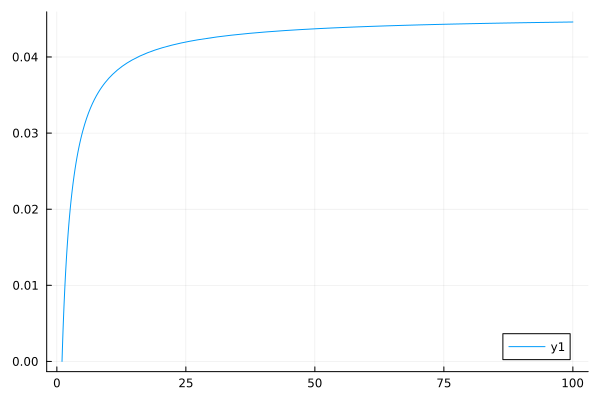

In [9]:
plot(LR, 1, 100)

In [10]:
η_rad = 1:0.1:10

bestrad, indexrad = findmax([LR(η) for η in η_rad])

η = η_rad[indexrad]

10.0

We move now to the strips

In [11]:
η_s = log(η)/2π
ρ_s = log(min(α_i(η), α_o(η)))/2π
η_s, ρ_s, ρ_s-η_s    

(0.3664677994397139, 0.40361956514781866, 0.037151765708104745)

We want to find now an $\alpha$ that minimizes the right hand side of
$$
||Lf-L_Kf||_{\ell^1}\leq \left(1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\infty, \alpha}	
$$


In [ ]:
function rhs(α, K; η, ρ)
    Dρα = ρ-α
    Dαη = α-η
    coeff_1 = 1+2*(exp(-2*π*(Dρα)))/(1-(exp(-2*π*(Dρα))))
    coeff_2 = exp(-2*π*K*α)+exp(-2*π*K*(Dαη))
    return coeff_1*coeff_2
end

rhs (generic function with 1 method)

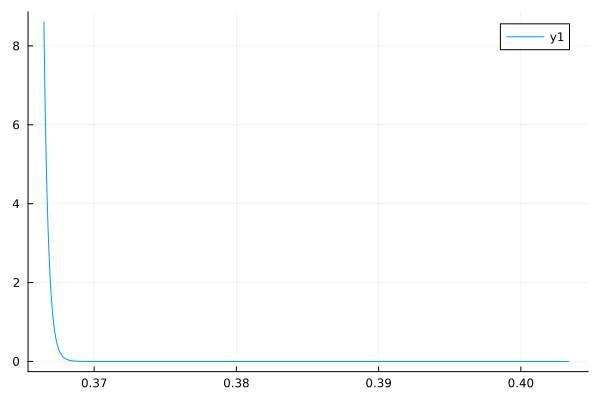

In [13]:
plot(α -> rhs(α, K; η = η_s, ρ = ρ_s), η_s, ρ_s)

In [14]:
α_arr = LinRange(η_s, ρ_s, 10000)
val_min, idx = findmin(map(α -> rhs(α, K; η = η_s, ρ = ρ_s), α_arr))
α_s = α_arr[idx]
val_min, α_s

(3.4599649993307605e-49, 0.40330745910526633)

We compute now the right hand side, supposing $|\mu|>1/2$
$$
||f||_{\infty, \alpha} \leq \left(\frac{1}{|\mu|}\right)^{\frac{\alpha}{\alpha-\eta}} \left( 1+2\frac{e^{-2 \pi |\rho-\alpha|}}{1-e^{-2 \pi |\rho-\alpha|}}\right)^{\frac{\alpha}{\alpha-\eta}} ||f||_{\ell^1}.
$$


In [15]:
function weak_strong(μ; η, α, ρ)
    s = α/(α-η)
    coeff_1 = (1/abs(μ))^s
    coeff_2 = 1+2*(exp(-2*π*(ρ-α)))/(1-(exp(-2*π*(ρ-α))))^s
    return coeff_1*coeff_2
end

weak_strong (generic function with 1 method)

In [16]:
bws = weak_strong(0.5; η = η_s, α = α_s, ρ = ρ_s)

1.7432099433662793e33

Clearly, the number above is ugly, but the fact that the projection error is small balances out. The `sqrt(N)` in the formula is the constant that relates
the $||.||_{\ell^1}$ norm and the $||.||_{\ell^2}$ norm. 

In [17]:
(bws*val_min)*sqrt(N)

1.931004708343623e-14

# Certifying the constants

For the specific values of $\alpha$, $\rho$ and $\eta$ computed above, we will certify the value of the constants.

In [18]:
using IntervalArithmetic

In [19]:
Ir = sqrt(interval(2))*17/32 
Iϕ = interval(π) / 8

max_r = 10.0
Iμ = Ir * exp(im * Iϕ)
IB(z; μ=Iμ) = (z * (μ - z)) / (1 - μ' * z)

IB (generic function with 1 method)

In [20]:
N = 16*1048576
Iα_o(ρ) = minimum(abs.(IB.([ρ * exp(im * 2 * interval(π) * interval(i, i+1)/N) for i in 0:N-1])))

Iα_o (generic function with 1 method)

In [21]:
Iα_i(ρ) = minimum(1.0 ./abs.(IB.([exp(im * 2 * interval(π) * interval(i, i+1)/N) / ρ for i in 0:N-1])))

Iα_i (generic function with 1 method)

In [22]:
α_o(ρ_s), α_i(ρ_s)

(0.201406895663498, 0.201406895663498)

In [23]:
ibound = Iα_i(ρ_s)

[0.201404, 0.201406]

In [24]:
obound = Iα_o(ρ_s)

[0.201404, 0.201406]

In [25]:
using RigorousInvariantMeasures, BallArithmetic

┌ Info: Switching to OpenBLAS with ConsistentFPCSR = 1 flag enabled, guarantees
│         correct floating point rounding mode over all threads.
└ @ BallArithmetic /home/isaia/.julia/packages/BallArithmetic/nPayJ/src/BallArithmetic.jl:20
┌ Info: OpenBLAS is giving correct rounding on a (1024,1024) test matrix on 6 threads
└ @ BallArithmetic /home/isaia/.julia/packages/BallArithmetic/nPayJ/src/BallArithmetic.jl:27


Generating forwards to /home/isaia/.julia/artifacts/7e6d3d1a151a3d510c0e5a4c8f2c792f53e39777/lib/libopenblas64_.so (clear: 0, verbose: 1, suffix_hint: '(null)')
 -> Autodetected symbol suffix "64_"
 -> Autodetected interface ILP64 (64-bit)
 -> Autodetected normal complex return style
 -> Autodetected gfortran calling convention
 -> CBLAS detected
Processed 5123 symbols; forwarded 4922 symbols with 64-bit interface and mangling to a suffix of "64_"


In [26]:

FourierBasis = RigorousInvariantMeasures.FourierAdjoint(K, 65536)

┌ Warning: This basis breaks the usual interface of the package, i.e., 
│     the dynamic is input as a function instead than a PwMap
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierAdjoint.jl:21


FFT on 65536 points restricted to highest frequency 512

In [27]:
S(x) = 0.5 + atan((sin(2 * pi * x) - r * sin(ϕ)) / (cos(2 * pi * x) - r * cos(ϕ))) / pi

S (generic function with 1 method)

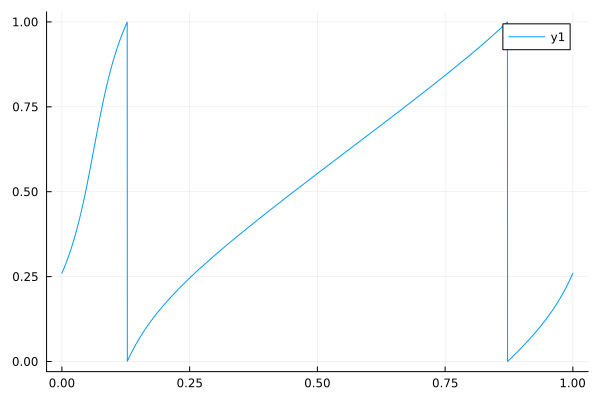

In [28]:
plot(S, 0, 1)

In [29]:
savefig("Blashke.png")

"/home/isaia/Code/ExperimentsPseudospectra.jl/notebook/Blashke.png"

In [30]:
P = DiscretizedOperator(FourierBasis, S)

┌ Info: Assembling operator, the Newton stopping options are 
│       ϵ = 1.0e-14, max_iter = 100
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/GenericAssembler.jl:145
┌ Info: 1025
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierCommon.jl:78
┌ Info: 512
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierCommon.jl:82
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


NonIntegralPreservingDiscretizedOperator{LinearAlgebra.Adjoint{Complex{Interval{Float64}}, Matrix{Complex{Interval{Float64}}}}, Vector{Float64}, LinearAlgebra.Adjoint{Complex{Interval{Float64}}, Vector{Complex{Interval{Float64}}}}}(Complex{Interval{Float64}}[[0.999999, 1.00001] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im … [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im; [-2.52734e-14, 2.51401e-14] + [-2.51685e-14, 2.52449e-14]im [0.694111, 0.694112] + [-0.287511, -0.28751]im … [-2.51936e-14, 2.52198e-14] + [-2.51893e-14, 2.52242e-14]im [-2.52183e-14, 2.51952e-14] + [-2.51881e-14, 2.52253e-14]im; … ; [-2.67231e-14, 2.66614e-14] + [-2.66875e-14, 2.66971e-14]im [-2.6676e-14, 2.67086e-14] + [-2.66656e-14, 2.67189e-14]im … [0.399128, 0.399129] + [0.399128, 0.399129]im [-2.67454e-14, 2.66391e-14] + [-2.67371e-14, 2.66475e-14]im; [-2.52734e-14, 2.51401e-14] + [-2.52449e-14,

In [31]:
import IntervalArithmetic
midI = IntervalArithmetic.mid
radI = IntervalArithmetic.radius

radius (generic function with 4 methods)

In [32]:
midP = midI.(real.(P.L)) + im * midI.(imag.(P.L))

1025×1025 Matrix{ComplexF64}:
          1.0+0.0im          …           0.0+0.0im
 -6.66496e-17+3.81792e-17im      -1.1549e-17+1.86067e-17im
 -3.08677e-17-4.79082e-18im      1.63007e-17-2.66466e-17im
 -7.57315e-17-3.89415e-17im     -4.31748e-17-3.71344e-17im
 -1.05844e-16+1.61218e-17im     -7.78535e-17-9.23976e-18im
 -5.76931e-17+3.91058e-17im  …  -3.16265e-17+1.64795e-17im
  -4.3188e-17-1.45419e-17im     -8.36798e-19-2.73783e-17im
 -8.23723e-17-4.02629e-17im      -5.9319e-17-4.39442e-17im
 -9.95247e-17+1.24498e-17im     -7.90027e-17+9.44092e-18im
 -5.33089e-17+3.46199e-17im      -2.4268e-17+1.94898e-17im
             ⋮               ⋱  
 -5.33089e-17-3.46199e-17im     -3.43889e-17-5.17265e-17im
 -9.95247e-17-1.24498e-17im     -8.37008e-17-2.68058e-17im
 -8.23723e-17+4.02629e-17im      -8.6234e-17+2.79269e-17im
  -4.3188e-17+1.45419e-17im     -2.41699e-17-4.65901e-18im
 -5.76931e-17-3.91058e-17im  …   -4.6237e-17-6.69562e-17im
 -1.05844e-16-1.61218e-17im     -9.82085e-17-2.61974e-17im
 

In [33]:
radP = sqrt.(radI.(real.(P.L))^2 + radI.(imag.(P.L))^2)

1025×1025 Matrix{Float64}:
 4.41975e-12  4.41975e-12  4.41975e-12  …  4.41975e-12  4.41975e-12
 4.5629e-12   4.5629e-12   4.5629e-12      4.5629e-12   4.5629e-12
 4.69543e-12  4.69543e-12  4.69543e-12     4.69543e-12  4.69543e-12
 4.82386e-12  4.82386e-12  4.82386e-12     4.82386e-12  4.82386e-12
 4.95014e-12  4.95014e-12  4.95014e-12     4.95014e-12  4.95014e-12
 5.05648e-12  5.05648e-12  5.05648e-12  …  5.05648e-12  5.05648e-12
 5.19125e-12  5.19125e-12  5.19125e-12     5.19125e-12  5.19125e-12
 5.31247e-12  5.31247e-12  5.31247e-12     5.31247e-12  5.31247e-12
 5.42379e-12  5.42379e-12  5.42379e-12     5.42379e-12  5.42379e-12
 5.52338e-12  5.52338e-12  5.52338e-12     5.52338e-12  5.52338e-12
 ⋮                                      ⋱               
 5.52338e-12  5.52338e-12  5.52338e-12     5.52338e-12  5.52338e-12
 5.42379e-12  5.42379e-12  5.42379e-12     5.42379e-12  5.42379e-12
 5.31247e-12  5.31247e-12  5.31247e-12     5.31247e-12  5.31247e-12
 5.19125e-12  5.19125e-12  5.1912

In [34]:
BallP = BallMatrix(midP, radP)

1025×1025 Matrix{Ball{Float64, ComplexF64}}:
                  1.0+0.0im ± 4.41975e-12  …                   0.0+0.0im ± 4.41975e-12
  -6.66496e-17+3.81792e-17im ± 4.5629e-12       -1.1549e-17+1.86067e-17im ± 4.5629e-12
 -3.08677e-17-4.79082e-18im ± 4.69543e-12      1.63007e-17-2.66466e-17im ± 4.69543e-12
 -7.57315e-17-3.89415e-17im ± 4.82386e-12     -4.31748e-17-3.71344e-17im ± 4.82386e-12
 -1.05844e-16+1.61218e-17im ± 4.95014e-12     -7.78535e-17-9.23976e-18im ± 4.95014e-12
 -5.76931e-17+3.91058e-17im ± 5.05648e-12  …  -3.16265e-17+1.64795e-17im ± 5.05648e-12
  -4.3188e-17-1.45419e-17im ± 5.19125e-12     -8.36798e-19-2.73783e-17im ± 5.19125e-12
 -8.23723e-17-4.02629e-17im ± 5.31247e-12      -5.9319e-17-4.39442e-17im ± 5.31247e-12
 -9.95247e-17+1.24498e-17im ± 5.42379e-12     -7.90027e-17+9.44092e-18im ± 5.42379e-12
 -5.33089e-17+3.46199e-17im ± 5.52338e-12      -2.4268e-17+1.94898e-17im ± 5.52338e-12
                                                                  ⋮  ⋱  
 -5.33089e-1

In [35]:
using Pseudospectra

Computing pseudospectra... 100%|████████████████████| Time: 0:00:21


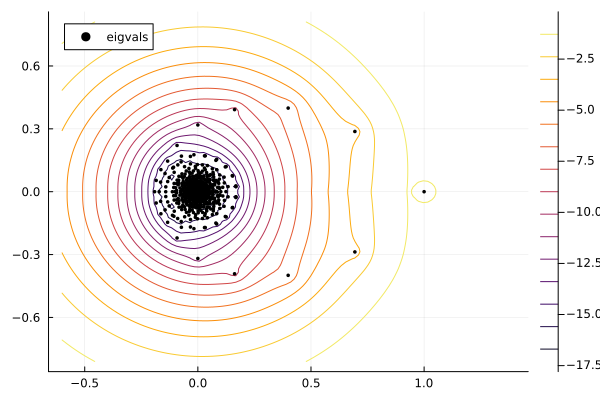

In [36]:
spectralportrait(midP)

In [37]:
savefig("PseudospectraGalerkinBlashke.png")

"/home/isaia/Code/ExperimentsPseudospectra.jl/notebook/PseudospectraGalerkinBlashke.png"

In [38]:
using LinearAlgebra
abs.(diag(schur(midP).T))

1025-element Vector{Float64}:
 0.7513009550106898
 0.751300955010684
 0.5644531250233265
 0.564453125024042
 0.4240741672174206
 0.4240741672769339
 0.3186085319892757
 0.3186084673000446
 0.2392158217087899
 0.2392166687611465
 ⋮
 2.8450808188099954e-15
 2.3905604358926875e-15
 2.4335223703674515e-15
 2.2148154817274752e-15
 1.699918565215941e-15
 1.9152349145962733e-15
 6.861686809829886e-16
 2.649402358090582e-16
 1.0

With this discretization size we are not going to separate 
things that are separated by less than $0.0025$.
By inspecting the eigenvalues of the Schur matrix, we see that it may be difficult to separate the eigenvalues with norm $0.522...$, that corresponde to a double eigenvalue.
Therefore we resolve to enclose a bigger circle than $0.5$.  